In [ ]:
import pandas as pd


# Load existing GWAS files
alz_file = "gwas-association-downloaded_2025-07-21-MONDO_0004975-withChildTraits.tsv"
t2d_file = "gwas-association-downloaded_2025-07-21-MONDO_0005148.tsv"
nafld_file = "gwas-association-downloaded_2025-07-21-EFO_0003095-withChildTraits.tsv"  # <- Replace with actual NAFLD file if different


alz = pd.read_csv(alz_file, sep="\t")
t2d = pd.read_csv(t2d_file, sep="\t")
nafld = pd.read_csv(nafld_file, sep="\t")


# Helper function to clean and extract gene symbols
def extract_genes(df):
   genes_col = df["REPORTED GENE(S)"].dropna().tolist() + df["MAPPED_GENE"].dropna().tolist()
   flat = [g.strip() for item in genes_col for g in str(item).replace(';', ',').split(',')]
   flat = [g for g in flat if g and g != '-' and g.isalpha() and not g.startswith("LOC") and not g.startswith("NR")]
   return sorted(set(flat))


# Extract clean gene sets
alz_genes = extract_genes(alz)
t2d_genes = extract_genes(t2d)
nafld_genes = extract_genes(nafld)


# Overlaps
shared_all = sorted(set(alz_genes) & set(t2d_genes) & set(nafld_genes))
shared_ad_nafld = sorted(set(alz_genes) & set(nafld_genes))
shared_t2d_nafld = sorted(set(t2d_genes) & set(nafld_genes))


# Save all sets
pd.DataFrame(alz_genes, columns=["Gene"]).to_csv("alz_genes.tsv", sep='\t', index=False)
pd.DataFrame(t2d_genes, columns=["Gene"]).to_csv("t2d_genes.tsv", sep='\t', index=False)
pd.DataFrame(nafld_genes, columns=["Gene"]).to_csv("nafld_genes.tsv", sep='\t', index=False)
pd.DataFrame(shared_all, columns=["Gene"]).to_csv("shared_AD_T2D_NAFLD.tsv", sep='\t', index=False)
pd.DataFrame(shared_ad_nafld, columns=["Gene"]).to_csv("shared_AD_NAFLD.tsv", sep='\t', index=False)
pd.DataFrame(shared_t2d_nafld, columns=["Gene"]).to_csv("shared_T2D_NAFLD.tsv", sep='\t', index=False)


# Display gene counts
print(f"🧠 Alzheimer's genes: {len(alz_genes)}")
print(f"🩸 T2D genes: {len(t2d_genes)}")
print(f"🧬 NAFLD genes: {len(nafld_genes)}\n")


print(f"🔗 Shared (AD ∩ T2D ∩ NAFLD): {len(shared_all)}")
print(f"🧠🔗 Shared (AD ∩ NAFLD): {len(shared_ad_nafld)}")
print(f"🩸🔗 Shared (T2D ∩ NAFLD): {len(shared_t2d_nafld)}")





🧠 Alzheimer's genes: 256
🩸 T2D genes: 275
🧬 NAFLD genes: 40

🔗 Shared (AD ∩ T2D ∩ NAFLD): 4
🧠🔗 Shared (AD ∩ NAFLD): 6
🩸🔗 Shared (T2D ∩ NAFLD): 22


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.6/597.6 kB 15.3 MB/s eta 0:00:00
✅ Cleaned gene counts:
AD: 105 genes
T2D: 117 genes
NAFLD: 37 genes

🔗 AD ∩ T2D → 6 shared genes
🧠 AD ∩ T2D network: 4 nodes, 4 edges
⭐ Hub-Bottlenecks (0): []


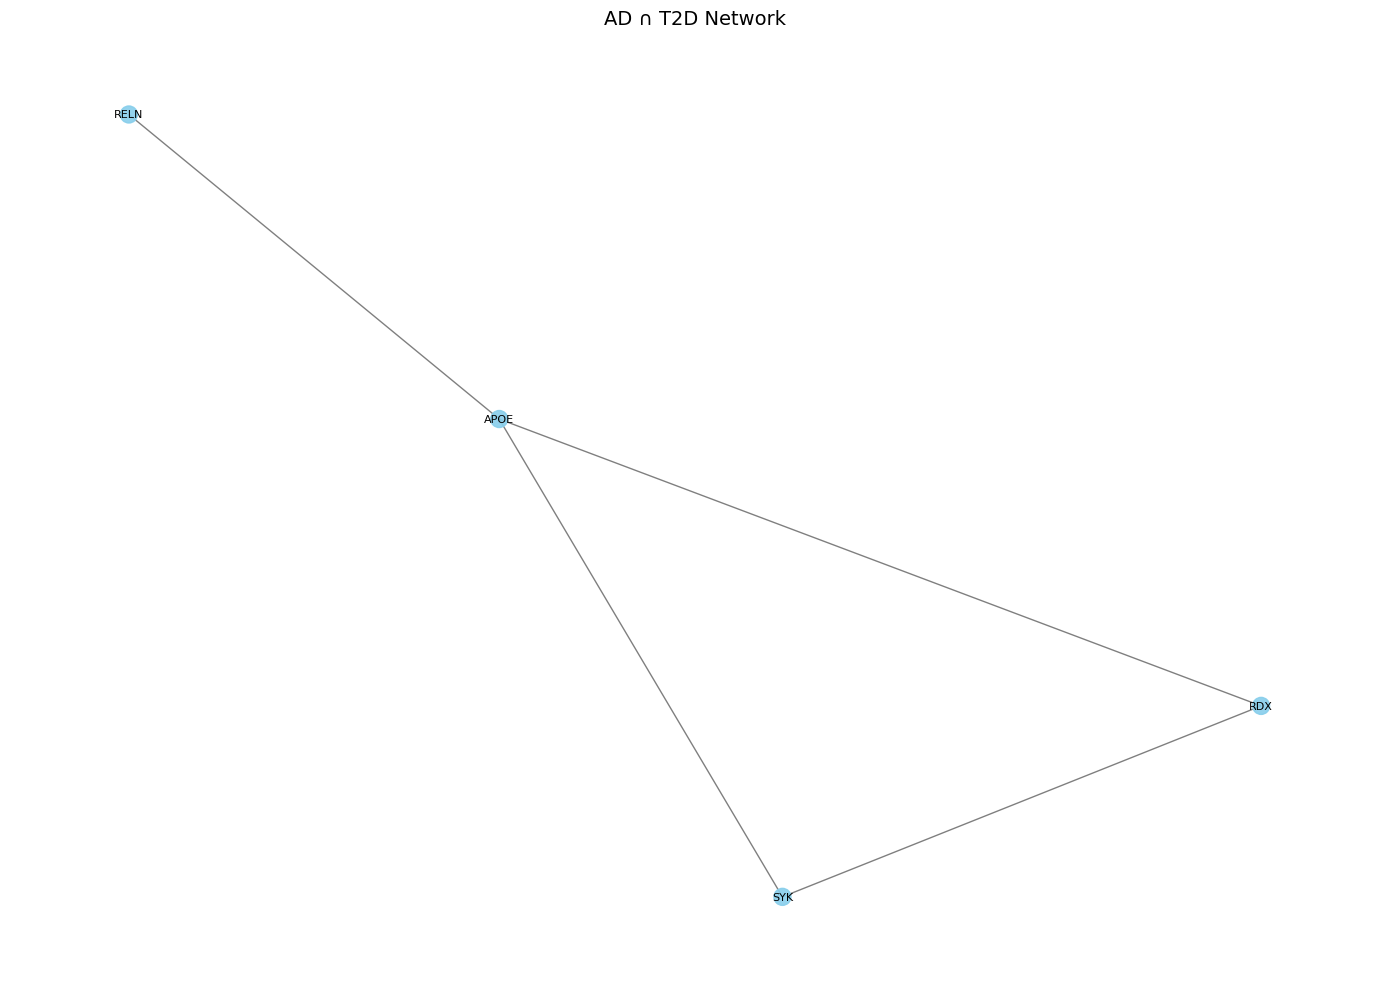


🔗 AD ∩ NAFLD → 2 shared genes
🧠 AD ∩ NAFLD network: 0 nodes, 0 edges
⭐ Hub-Bottlenecks (0): []
⚠️ AD ∩ NAFLD Network: No interactions found.

🔗 T2D ∩ NAFLD → 13 shared genes
🧠 T2D ∩ NAFLD network: 9 nodes, 24 edges
⭐ Hub-Bottlenecks (0): []


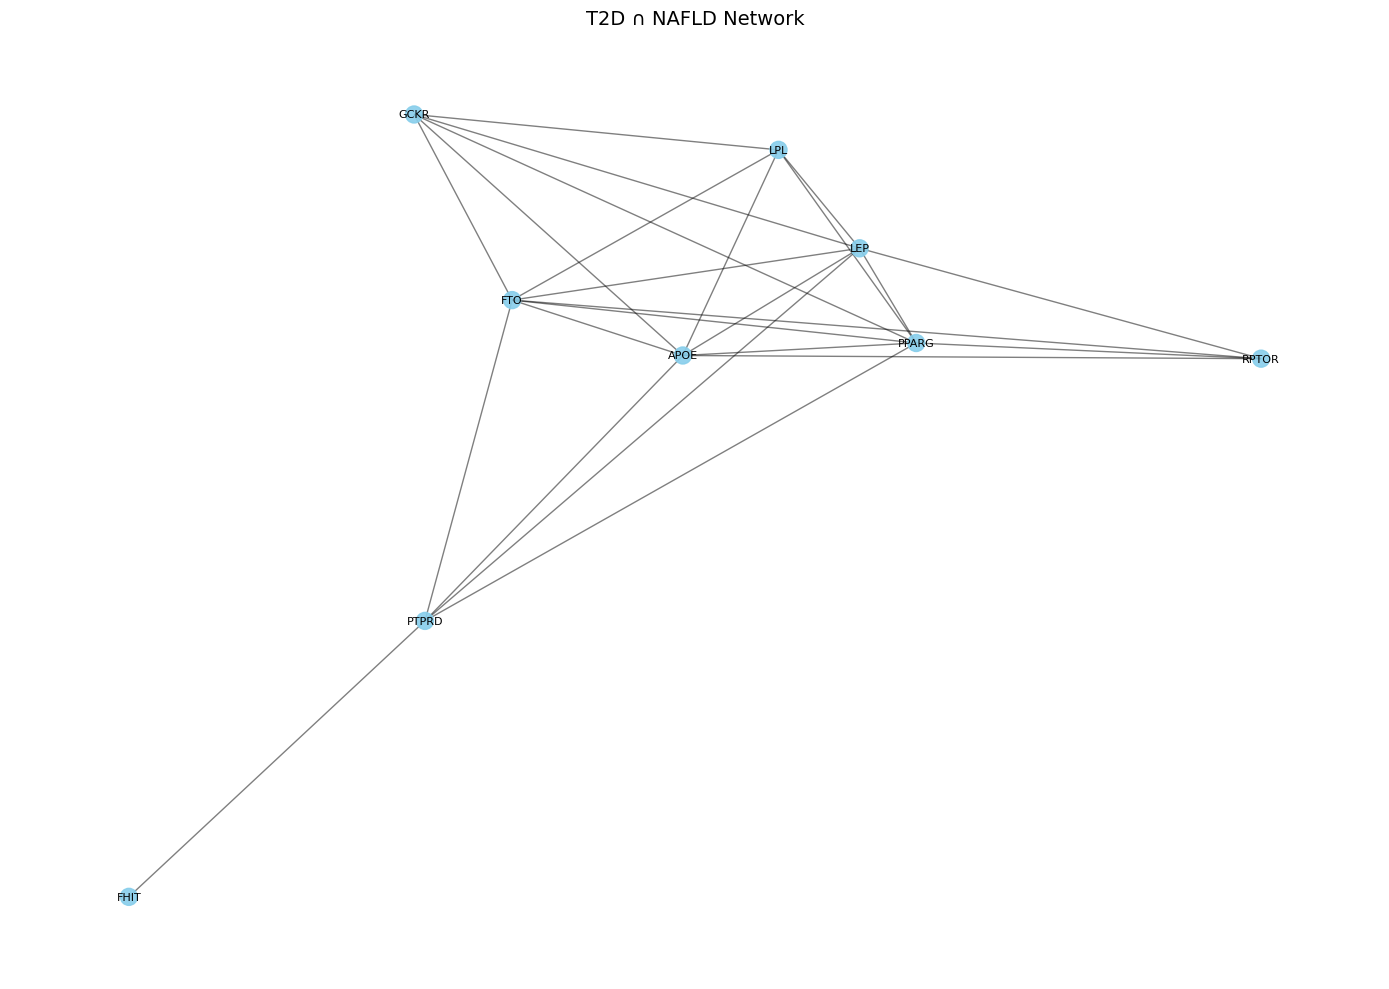


🔗 AD ∩ T2D ∩ NAFLD → 1 shared genes
⚠️ Too few genes to create a network.


In [ ]:
# STEP 1: Install required packages
!pip install gseapy networkx matplotlib requests tqdm

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gseapy as gp
import requests
from tqdm import tqdm

# STEP 2: Load gene lists (upload your files first)
alz = pd.read_csv("alz_genes.tsv", sep="\t", header=None)[0].dropna().unique()
t2d = pd.read_csv("t2d_genes.tsv", sep="\t", header=None)[0].dropna().unique()
nafld = pd.read_csv("nafld_genes.tsv", sep="\t", header=None)[0].dropna().unique()

disease_genes = {
    "AD": set(alz),
    "T2D": set(t2d),
    "NAFLD": set(nafld)
}

# STEP 3: Clean gene names
def clean_gene_list(gene_set):
    return {g for g in gene_set if g.isalpha() and g.isupper() and len(g) > 2}

for d in disease_genes:
    disease_genes[d] = clean_gene_list(disease_genes[d])

print("✅ Cleaned gene counts:")
for d, g in disease_genes.items():
    print(f"{d}: {len(g)} genes")

# STEP 4: STRING PPI fetch (lower score = 0.7)
def fetch_string_ppi(gene_list, species=9606, cutoff=0.7):
    url = "https://string-db.org/api/json/network"
    params = {
        "identifiers": "%0d".join(gene_list),
        "species": species,
        "required_score": int(cutoff * 1000)
    }
    response = requests.post(url, data=params)
    if response.ok:
        return response.json()
    else:
        raise Exception("STRING API failed")

# STEP 5: Build networkx graph
def build_graph(interactions):
    G = nx.Graph()
    for edge in interactions:
        G.add_edge(edge["preferredName_A"], edge["preferredName_B"], weight=edge["score"])
    return G

# STEP 6: Detect hub-bottlenecks
def find_hub_bottlenecks(G):
    if G.number_of_nodes() == 0:
        return set()
    deg = dict(G.degree())
    btw = nx.betweenness_centrality(G)

    deg_vals = list(deg.values())
    mean_deg = sum(deg_vals) / len(deg_vals)
    std_deg = pd.Series(deg_vals).std()
    deg_cutoff = mean_deg + 2 * std_deg

    hubs = {n for n in G.nodes if deg[n] > deg_cutoff}
    top_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)
    bottlenecks = {n for n, _ in top_btw[:max(1, int(0.05 * len(G)))]}
    return hubs & bottlenecks

# STEP 7: Visualize networks with all genes labeled
def visualize_tagged_network(G, hubs, title):
    if G.number_of_nodes() == 0:
        print(f"⚠️ {title}: No interactions found.")
        return

    pos = nx.spring_layout(G, seed=42)
    node_colors = ["red" if n in hubs else "skyblue" for n in G.nodes]
    node_sizes = [400 if n in hubs else 150 for n in G.nodes]

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# STEP 8: Analyze all pairwise + 3-way overlaps
intersections = {
    "AD ∩ T2D": disease_genes["AD"] & disease_genes["T2D"],
    "AD ∩ NAFLD": disease_genes["AD"] & disease_genes["NAFLD"],
    "T2D ∩ NAFLD": disease_genes["T2D"] & disease_genes["NAFLD"],
    "AD ∩ T2D ∩ NAFLD": disease_genes["AD"] & disease_genes["T2D"] & disease_genes["NAFLD"]
}

for label, genes in intersections.items():
    print(f"\n🔗 {label} → {len(genes)} shared genes")
    if len(genes) < 2:
        print("⚠️ Too few genes to create a network.")
        continue

    try:
        string_data = fetch_string_ppi(list(genes), cutoff=0.15)  # Lower STRING score
        G = build_graph(string_data)
        hubs = find_hub_bottlenecks(G)

        print(f"🧠 {label} network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        print(f"⭐ Hub-Bottlenecks ({len(hubs)}): {sorted(hubs)}")

        visualize_tagged_network(G, hubs, f"{label} Network")

    except Exception as e:
        print(f"❌ Error for {label}: {str(e)}")


✅ Cleaned gene counts:
AD: 105 genes
T2D: 117 genes
NAFLD: 37 genes

🔄 Building STRING PPI for AD (105 genes)...
🧠 AD network: 28 nodes, 39 edges
⭐ Hub-Bottlenecks (1): ['APOE']

🔄 Building STRING PPI for T2D (117 genes)...
🧠 T2D network: 38 nodes, 52 edges
⭐ Hub-Bottlenecks (1): ['INS']

🔄 Building STRING PPI for NAFLD (37 genes)...
🧠 NAFLD network: 17 nodes, 20 edges
⭐ Hub-Bottlenecks (1): ['LEP']


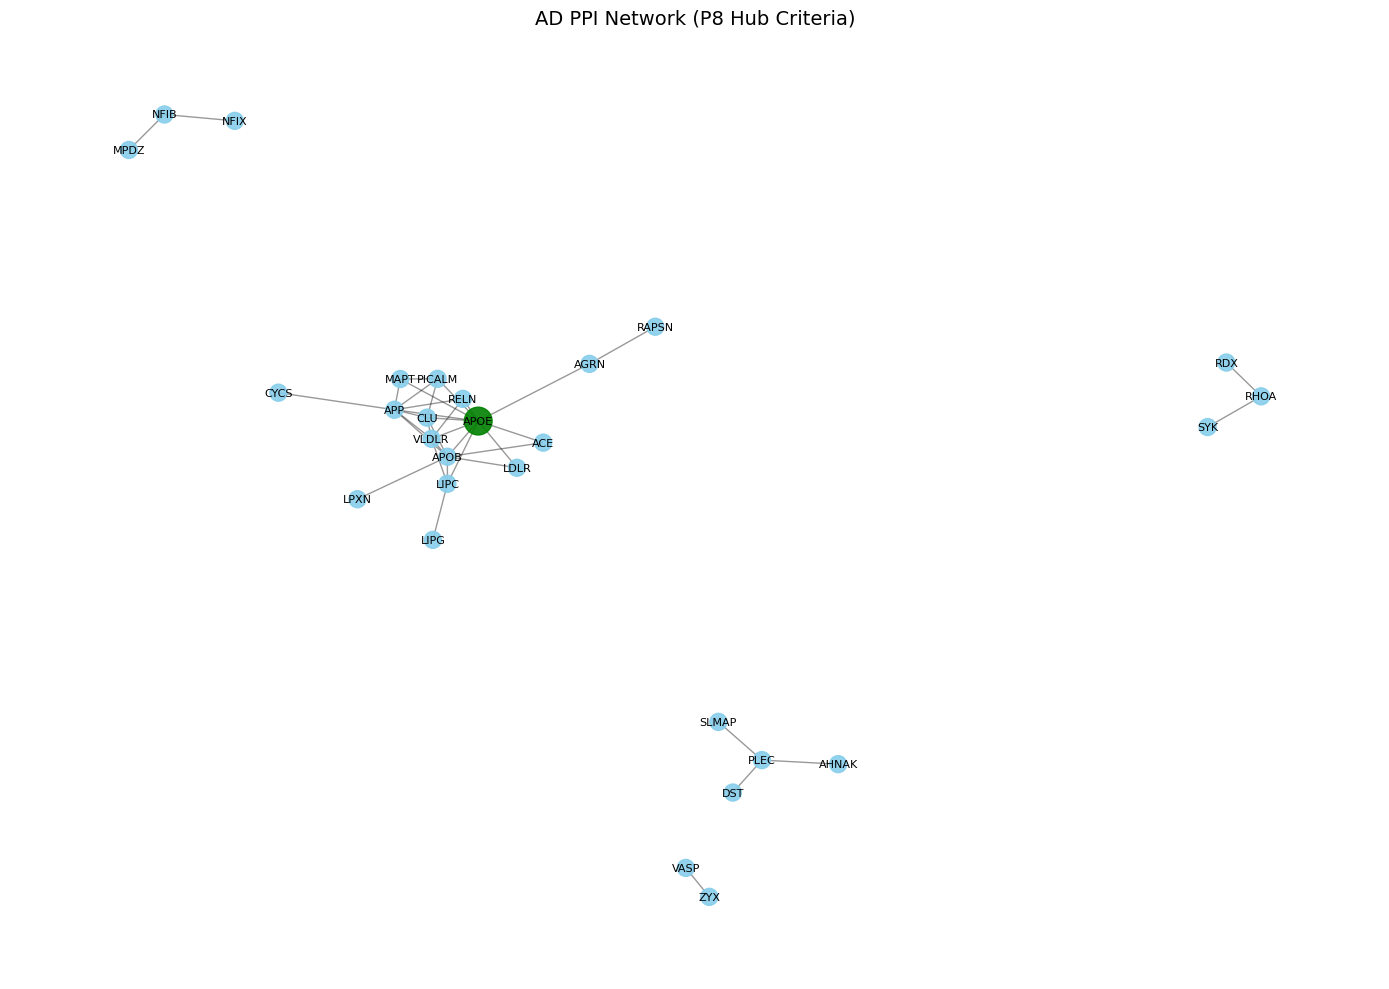

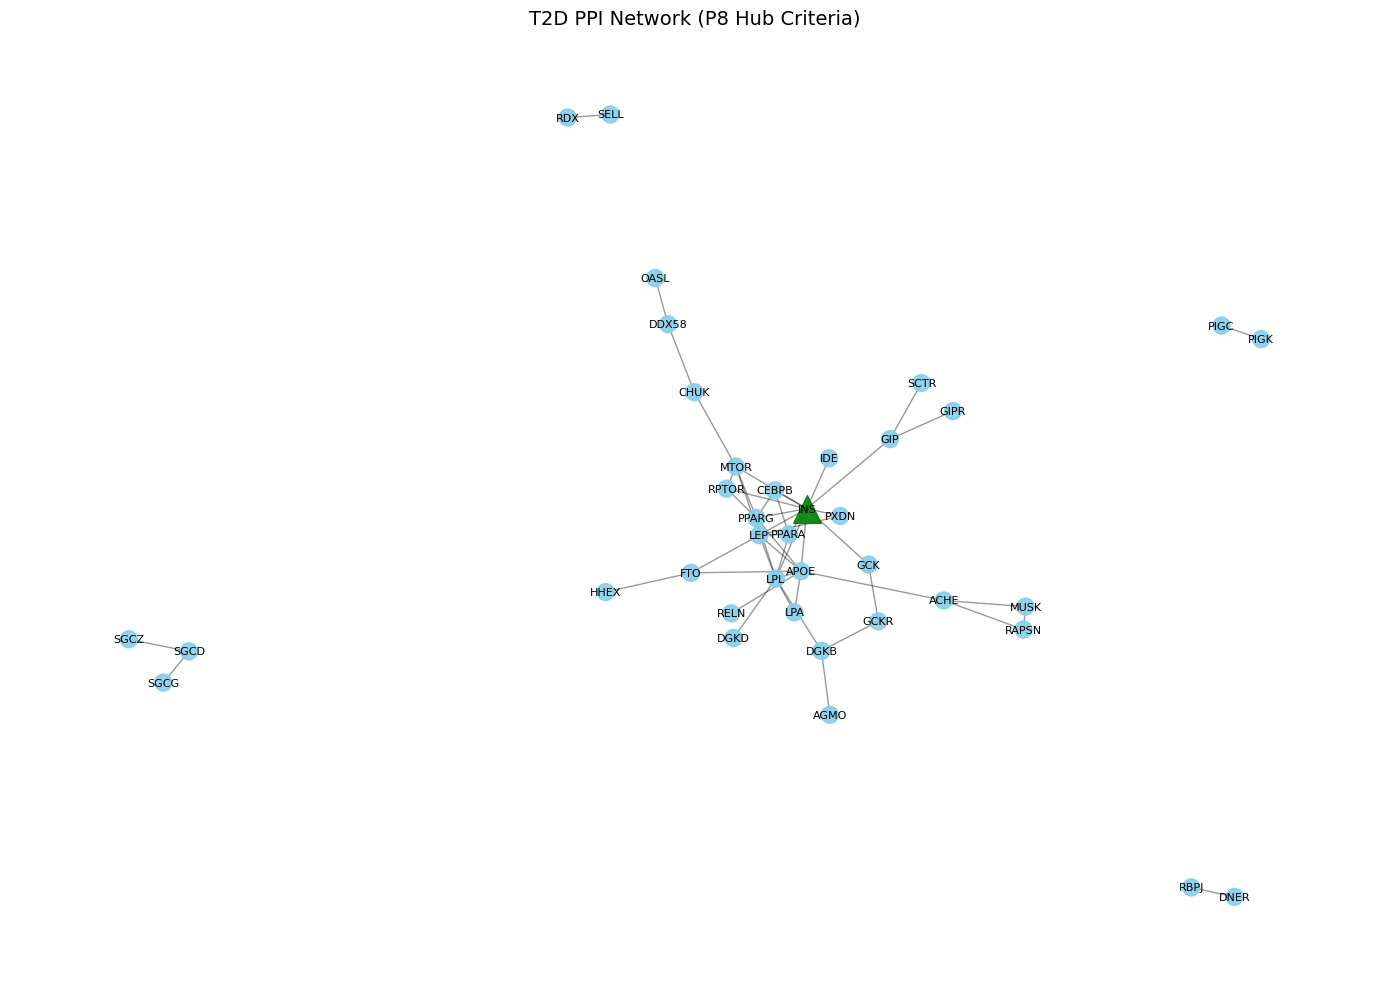

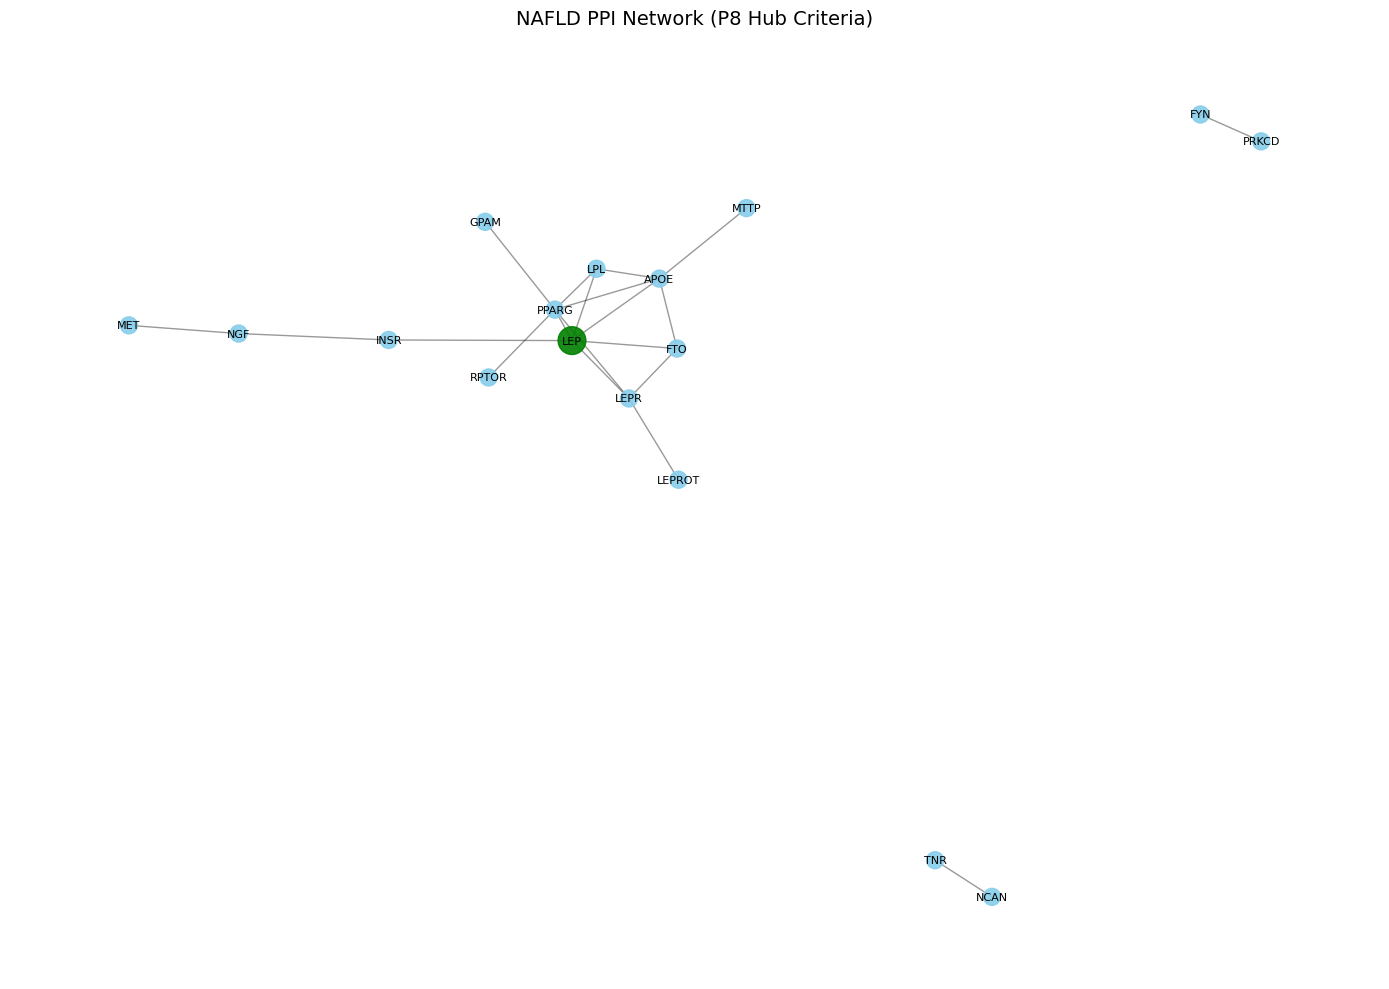

In [ ]:
# STEP 1: Install required packages
!pip install gseapy networkx matplotlib requests tqdm

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import gseapy as gp
import requests
from tqdm import tqdm

# STEP 2: Load gene lists (upload these files)
alz = pd.read_csv("alz_genes.tsv", sep="\t", header=None)[0].dropna().unique()
t2d = pd.read_csv("t2d_genes.tsv", sep="\t", header=None)[0].dropna().unique()
nafld = pd.read_csv("nafld_genes.tsv", sep="\t", header=None)[0].dropna().unique()

disease_genes = {
    "AD": set(alz),
    "T2D": set(t2d),
    "NAFLD": set(nafld)
}

# STEP 3: Clean gene names
def clean_gene_list(gene_set):
    return {g for g in gene_set if g.isalpha() and g.isupper() and len(g) > 2}

for d in disease_genes:
    disease_genes[d] = clean_gene_list(disease_genes[d])

print("✅ Cleaned gene counts:")
for d, g in disease_genes.items():
    print(f"{d}: {len(g)} genes")

# STEP 4: STRING PPI fetch
def fetch_string_ppi(gene_list, species=9606, cutoff=0.7):
    url = "https://string-db.org/api/json/network"
    params = {
        "identifiers": "%0d".join(gene_list),
        "species": species,
        "required_score": int(cutoff * 1000)
    }
    response = requests.post(url, data=params)
    if response.ok:
        return response.json()
    else:
        raise Exception("STRING API failed")

# STEP 5: Build graph
def build_graph(interactions):
    G = nx.Graph()
    for edge in interactions:
        G.add_edge(edge["preferredName_A"], edge["preferredName_B"], weight=edge["score"])
    return G

# STEP 6: P8-style hub-bottleneck detection (top 5% of degree + betweenness + closeness)
def find_hub_bottlenecks_p8(G):
    if G.number_of_nodes() == 0:
        return set()

    deg = dict(G.degree())
    btw = nx.betweenness_centrality(G)
    cls = nx.closeness_centrality(G)

    top_n = max(1, int(0.05 * len(G)))

    top_deg = {k for k, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:top_n]}
    top_btw = {k for k, _ in sorted(btw.items(), key=lambda x: x[1], reverse=True)[:top_n]}
    top_cls = {k for k, _ in sorted(cls.items(), key=lambda x: x[1], reverse=True)[:top_n]}

    return top_deg & top_btw & top_cls

# STEP 7: Visualize with green triangle for T2D hubs
def visualize_with_t2d_hubs(G, hubs, title, t2d_hubs):
    if G.number_of_nodes() == 0:
        print(f"⚠️ {title}: No interactions found.")
        return

    pos = nx.spring_layout(G, seed=42)
    node_shapes = {"triangle": [], "circle": []}
    node_colors = {}

    for n in G.nodes:
        is_hub = n in hubs
        is_t2d_hub = n in t2d_hubs
        if is_hub and is_t2d_hub:
            node_shapes["triangle"].append(n)
            node_colors[n] = "green"
        elif is_hub:
            node_shapes["circle"].append(n)
            node_colors[n] = "green"
        else:
            node_shapes["circle"].append(n)
            node_colors[n] = "skyblue"

    plt.figure(figsize=(14, 10))
    for shape, nodes in node_shapes.items():
        if not nodes:
            continue
        node_size = [400 if n in hubs else 150 for n in nodes]
        color = [node_colors[n] for n in nodes]
        if shape == "triangle":
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape="^", node_color=color, node_size=node_size, alpha=0.9)
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_shape="o", node_color=color, node_size=node_size, alpha=0.9)

    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# STEP 8: Build full PPI networks and detect hub-bottlenecks (P8 method)
full_networks = {}
hub_bottlenecks = {}

for disease, genes in disease_genes.items():
    print(f"\n🔄 Building STRING PPI for {disease} ({len(genes)} genes)...")
    try:
        string_data = fetch_string_ppi(list(genes), cutoff=0.7)
        G = build_graph(string_data)
        hubs = find_hub_bottlenecks_p8(G)

        full_networks[disease] = G
        hub_bottlenecks[disease] = hubs

        print(f"🧠 {disease} network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        print(f"⭐ Hub-Bottlenecks ({len(hubs)}): {sorted(hubs)}")

    except Exception as e:
        print(f"❌ Error building network for {disease}: {str(e)}")

# STEP 9: Visualize networks with triangle marker for T2D hubs
t2d_hubs = hub_bottlenecks.get("T2D", set())

for disease in ["AD", "T2D", "NAFLD"]:
    G = full_networks[disease]
    hubs = hub_bottlenecks[disease]
    visualize_with_t2d_hubs(G, hubs, f"{disease} PPI Network (P8 Hub Criteria)", t2d_hubs)


In [ ]:
import pandas as pd

# Load existing GWAS files
alz_file = "gwas-association-downloaded_2025-07-21-MONDO_0004975-withChildTraits.tsv"
t2d_file = "gwas-association-downloaded_2025-07-21-MONDO_0005148.tsv"
nafld_file = "gwas-association-downloaded_2025-07-21-EFO_0003095-withChildTraits.tsv"  # <- Replace with actual NAFLD file if different

alz = pd.read_csv(alz_file, sep="\t")
t2d = pd.read_csv(t2d_file, sep="\t")
nafld = pd.read_csv(nafld_file, sep="\t")

# Helper function to clean and extract gene symbols
def extract_genes(df):
    genes_col = df["REPORTED GENE(S)"].dropna().tolist() + df["MAPPED_GENE"].dropna().tolist()
    flat = [g.strip() for item in genes_col for g in str(item).replace(';', ',').split(',')]
    flat = [g for g in flat if g and g != '-' and g.isalpha() and not g.startswith("LOC") and not g.startswith("NR")]
    return sorted(set(flat))

# Extract clean gene sets
alz_genes = extract_genes(alz)
t2d_genes = extract_genes(t2d)
nafld_genes = extract_genes(nafld)

# Overlaps
shared_all = sorted(set(alz_genes) & set(t2d_genes) & set(nafld_genes))
shared_ad_nafld = sorted(set(alz_genes) & set(nafld_genes))
shared_t2d_nafld = sorted(set(t2d_genes) & set(nafld_genes))

# Save all sets
pd.DataFrame(alz_genes, columns=["Gene"]).to_csv("alz_genes.tsv", sep='\t', index=False)
pd.DataFrame(t2d_genes, columns=["Gene"]).to_csv("t2d_genes.tsv", sep='\t', index=False)
pd.DataFrame(nafld_genes, columns=["Gene"]).to_csv("nafld_genes.tsv", sep='\t', index=False)
pd.DataFrame(shared_all, columns=["Gene"]).to_csv("shared_AD_T2D_NAFLD.tsv", sep='\t', index=False)
pd.DataFrame(shared_ad_nafld, columns=["Gene"]).to_csv("shared_AD_NAFLD.tsv", sep='\t', index=False)
pd.DataFrame(shared_t2d_nafld, columns=["Gene"]).to_csv("shared_T2D_NAFLD.tsv", sep='\t', index=False)

# Display gene counts
print(f"🧠 Alzheimer's genes: {len(alz_genes)}")
print(f"🩸 T2D genes: {len(t2d_genes)}")
print(f"🧬 NAFLD genes: {len(nafld_genes)}\n")

print(f"🔗 Shared (AD ∩ T2D ∩ NAFLD): {len(shared_all)}")
print(f"🧠🔗 Shared (AD ∩ NAFLD): {len(shared_ad_nafld)}")
print(f"🩸🔗 Shared (T2D ∩ NAFLD): {len(shared_t2d_nafld)}")


🧠 Alzheimer's genes: 256
🩸 T2D genes: 275
🧬 NAFLD genes: 40

🔗 Shared (AD ∩ T2D ∩ NAFLD): 4
🧠🔗 Shared (AD ∩ NAFLD): 6
🩸🔗 Shared (T2D ∩ NAFLD): 22
